#**Data Collection and Image Preprocessing**

##**Importing the Dataset**

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle

In [ ]:
!kaggle competitions download -c dog-breed-identification

 99% 686M/691M [00:05<00:00, 122MB/s]
100% 691M/691M [00:05<00:00, 141MB/s]


In [ ]:
!unzip /content/dog-breed-identification.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: train/83fad0718581a696132c96c166472627.jpg  
  inflating: train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: train/840db91ba4600148f3dcb06ec419b421.jpg  
  inflating: train/840dbad5a691c22611d85b2488bf4cbb.jpg  
  inflating: train/8410ced9ebc1759a7ebce5c42bfb5222.jpg  
  inflating: train/84

##**Organizing the Images into Different Classes**

In [ ]:
import numpy as np
import pandas as pd
import os
import shutil
import sys

In [ ]:
trainpath='/content/train'
testpath='/content/test'
labels=pd.read_csv('/content/labels.csv')

In [ ]:
classes=len(labels.breed.unique())
classes

120

In [ ]:
def make_dir(x):
    if os.path.exists(x)==False:
       os.makedirs(x)
base_dir='./subset'
make_dir(base_dir)

In [ ]:
train_dir=os.path.join(base_dir,'train')
make_dir(train_dir)

In [ ]:
breeds=labels.breed.unique()
for breed in breeds:
    # Making folder for each breed
    _=os.path.join(train_dir,breed)
    make_dir(_)
    # Copying images to the correspondiing folders
    images=labels[labels.breed==breed]['id']
    for image in images:
        source=os.path.join(trainpath,f'{image}.jpg')
        destination=os.path.join(train_dir,breed,f'{image}.jpg')
        shutil.copyfile(source,destination)

In [ ]:
breeds

array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever',
       'bedlington_terrier', 'borzoi', 'basenji', 'scottish_deerhound',
       'shetland_sheepdog', 'walker_hound', 'maltese_dog',
       'norfolk_terrier', 'african_hunting_dog',
       'wire-haired_fox_terrier', 'redbone', 'lakeland_terrier', 'boxer',
       'doberman', 'otterhound', 'standard_schnauzer',
       'irish_water_spaniel', 'black-and-tan_coonhound', 'cairn',
       'affenpinscher', 'labrador_retriever', 'ibizan_hound',
       'english_setter', 'weimaraner', 'giant_schnauzer', 'groenendael',
       'dhole', 'toy_poodle', 'border_terrier', 'tibetan_terrier',
       'norwegian_elkhound', 'shih-tzu', 'irish_terrier', 'kuvasz',
       'german_shepherd', 'greater_swiss_mountain_dog', 'basset',
       'australian_terrier', 'schipperke', 'rhodesian_ridgeback',
       'irish_setter', 'appenzeller', 'bloodhound', 'samoyed',
       'miniature_schnauzer', 'brittany_spaniel', 'kelpie', 'papillon',
       'borde

##**Import Data Generator Library**

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

##**Configure Image Data Generator Class**

In [ ]:
datagen=ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True,validation_split=0.2)

##**Apply Image Data Generator Functionality to Training Set and Testing Set**

In [ ]:
train_generator=datagen.flow_from_directory(directory=train_dir,target_size=(224,224),batch_size=32,class_mode='categorical',subset='training',shuffle=False,
                                            classes=['affenpinscher','beagle','appenzeller','basset','bluetick','boxer','cairn','doberman','german_shepherd','golden_retriever',
                                                     'kelpie','komondor','leonberg','mexican_hairless','pug','redbone','shih-tzu','toy_poodle','vizsla','whippe'])

Found 1276 images belonging to 20 classes.


In [ ]:
validation_generator=datagen.flow_from_directory(directory=train_dir,target_size=(224,224),batch_size=32,class_mode='categorical',subset='validation',shuffle=False,
                                            classes=['affenpinscher','beagle','appenzeller','basset','bluetick','boxer','cairn','doberman','german_shepherd','golden_retriever',
                                                     'kelpie','komondor','leonberg','mexican_hairless','pug','redbone','shih-tzu','toy_poodle','vizsla','whippe'])

Found 312 images belonging to 20 classes.


#**Model Building**

##**Import Model Building Libraries**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.utils import image_dataset_from_directory
from keras.callbacks import EarlyStopping
from keras.activations import softmax
from keras.api._v2.keras import activations

In [ ]:
from keras.applications.vgg19 import VGG19
from keras.layers import Dense,Flatten,GlobalAveragePooling2D,Dropout
from keras.models import Model,Sequential
from keras.optimizers import Adam

##**Initializing the Model**

In [ ]:
vgg19_model=VGG19(input_shape=(224,224,3),weights='imagenet',include_top=False)

80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
vgg19_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
vgg19_model.trainable=False

In [ ]:
model=Sequential()
model.add(vgg19_model)
model.add(GlobalAveragePooling2D())

##**Adding Fully Connected Layers**

In [ ]:
model.add(Dropout(0.2))
model.add(Dense(20,activation="softmax"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 20)                10260     
                                                                 
Total params: 20,034,644
Trainable params: 10,260
Non-trainable params: 20,024,384
_________________________________________________________________


#**Configure the Learning Process**

In [ ]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["AUC"])

In [ ]:
model.fit(train_generator,steps_per_epoch=train_generator.samples//32,epochs=15,validation_data=validation_generator,validation_steps=validation_generator.samples//32,verbose=1)

Epoch 1/15
39/39 [==============================] - 1329s 34s/step - loss: 3.5566 - auc: 0.4473 - val_loss: 3.0597 - val_auc: 0.5634
Epoch 2/15
39/39 [==============================] - 1312s 34s/step - loss: 3.1818 - auc: 0.4997 - val_loss: 2.9421 - val_auc: 0.5880
Epoch 3/15
39/39 [==============================] - 1294s 33s/step - loss: 3.1126 - auc: 0.4959 - val_loss: 2.8839 - val_auc: 0.6371
Epoch 4/15
39/39 [==============================] - 1312s 34s/step - loss: 3.0397 - auc: 0.5397 - val_loss: 2.8414 - val_auc: 0.6650
Epoch 5/15
39/39 [==============================] - 1288s 33s/step - loss: 3.0394 - auc: 0.5308 - val_loss: 2.8212 - val_auc: 0.6776
Epoch 6/15
39/39 [==============================] - 1291s 33s/step - loss: 3.0056 - auc: 0.5519 - val_loss: 2.8223 - val_auc: 0.6846
Epoch 7/15
39/39 [==============================] - 1305s 34s/step - loss: 2.9959 - auc: 0.5573 - val_loss: 2.8016 - val_auc: 0.7029
Epoch 8/15
39/39 [==============================] - 1304s 34s/step - 

In [ ]:
model.save("dogBreed.h5")

In [ ]:
#Test the model
import tensorflow as tf
import numpy as np
from tensorflow import keras
from keras.models import load_model
from keras.utils import load_img,img_to_array

In [ ]:
model=tf.keras.models.load_model(r'/content/dogBreed.h5',compile=False)
img=load_img(r'/content/subset/train/leonberg/0287b3374c33346e2b41f73af3a36261.jpg',target_size=(224,224))

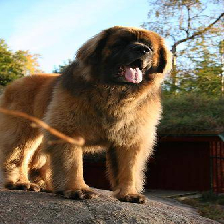

In [ ]:
img

In [ ]:
x=img_to_array(img)
x

array([[[169., 222., 253.],
        [170., 223., 254.],
        [171., 224., 255.],
        ...,
        [181., 202., 233.],
        [171., 188., 216.],
        [148., 163., 182.]],

       [[171., 224., 255.],
        [172., 225., 255.],
        [173., 227., 255.],
        ...,
        [186., 205., 245.],
        [181., 199., 235.],
        [183., 197., 224.]],

       [[174., 228., 255.],
        [175., 229., 255.],
        [176., 230., 255.],
        ...,
        [170., 192., 233.],
        [177., 197., 232.],
        [182., 197., 226.]],

       ...,

       [[ 59.,  49.,  40.],
        [ 95.,  85.,  76.],
        [ 79.,  69.,  60.],
        ...,
        [ 69.,  65.,  56.],
        [ 81.,  74.,  66.],
        [ 80.,  73.,  65.]],

       [[ 82.,  75.,  69.],
        [ 89.,  82.,  76.],
        [ 99.,  92.,  86.],
        ...,
        [ 59.,  49.,  39.],
        [ 59.,  49.,  40.],
        [ 67.,  61.,  49.]],

       [[ 82.,  77.,  73.],
        [ 88.,  83.,  79.],
        [ 93.,  

In [ ]:
x=np.expand_dims(x,axis=0)
x.ndim

4

In [ ]:
pred=model.predict(x)
pred

1/1 [==============================] - 2s 2s/step


array([[2.2137506e-17, 4.2152358e-11, 4.6075007e-18, 4.7354961e-18,
        3.5829362e-14, 1.3901305e-18, 2.5899658e-08, 6.7004033e-16,
        4.5035032e-16, 6.7812824e-21, 6.9963089e-12, 4.7548118e-25,
        1.0000000e+00, 0.0000000e+00, 4.5426563e-37, 3.3009727e-31,
        1.0745381e-13, 4.3751806e-31, 2.0400598e-21, 0.0000000e+00]],
      dtype=float32)

In [ ]:
pred_class=np.argmax(pred,axis=1)
pred_class[0]

12

In [ ]:
index=['affenpinscher','beagle','appenzeller','basset','bluetick','boxer','cairn','doberman','kelpie','golden_retriever',
       'german_shepherd','komondor','leonberg','mexican_hairless','pug','redbone','shih-tzu','toy_poodle','vizsla','whippet']
result=index[pred_class[0]]

In [ ]:
result

'leonberg'